In [2]:
import os
import json
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib_venn import venn2

wd = "projects/empathi"

### Stats

In [3]:
known = pd.read_pickle(os.path.join(wd, "data/proteins_wKnown_functions.pkl"))
unknown = pd.read_pickle(os.path.join(wd, "data/proteins_wUnknown_functions.pkl"))

#### PHROGs annotations

In [4]:
anno = pd.read_csv("phrog_index.csv") #as downloaded from PHROGs
anno = anno.loc[:, ["#phrog", "Pfam_hit", "Annotation", "Category"]]

phrogs = pd.DataFrame()
for i in list(range(0, 40)) + ["wrong_accession"]:
    if type(i) == int:
        subset = '{0:0>2}'.format(i)
    else:
        subset = i
    phrog = pd.read_csv(os.path.join(wd, f"out/phrogs/results_phrogs_{subset}.filt.tsv"), sep="\t", header=None, low_memory=False)
    phrog.columns = ["query", "target", "pident", "length", "mismatch", "gapopen", "qstart", "qend", "sstart", "send", "evalue", "bitscore"]
    phrog = phrog.loc[:, ["query", "target","evalue"]]
    
    phrog = pd.merge(phrog, anno, how="left", left_on="target", right_on="#phrog")

    phrogs = pd.concat([phrogs, phrog])

phrogs2 = phrogs.loc[phrogs["query"].isin(unknown.index)]
phrogs2 = phrogs2.loc[~phrogs2.Annotation.isna()] #remove PHROGs with NA annotation
phrogs2 = phrogs2.loc[phrogs2["Annotation"] != "unknown function"] #remove PHROGs with unknown annotation

phrogs2 = phrogs2.sort_values("evalue").drop_duplicates("query")
phrogs_2nd = list(phrogs2["query"])

In [6]:
print(f"Total # of proteins with known functions {known.shape[0]}.")
print(f"Total # of dereplicated proteins with known functions {known.loc[:, 0:1023].drop_duplicates().shape[0]}.")
print(f"Total # of protein clusters with known functions {len(known.pc.unique())}.")

Total # of proteins with known functions 845730.
Total # of dereplicated proteins with known functions 417297.
Total # of protein clusters with known functions 49380.


In [7]:
print(f"Total # of proteins with unknown functions {unknown.shape[0]}.")
print(f"Total # of dereplicated proteins with unknown functions {unknown.loc[:, 0:1023].drop_duplicates().shape[0]}.")
print(f"Total # of protein clusters with unknown functions {len(unknown.pc.unique())}.")

Total # of proteins with unknown functions 1008171.
Total # of dereplicated proteins with unknown functions 487140.
Total # of protein clusters with unknown functions 150788.


#### Empathi preds

In [6]:
preds = pd.read_csv(os.path.join(wd, "tmp/unknown/predictions_unknown.csv"), index_col=0)
unknown = pd.read_pickle(os.path.join(wd, "data/proteins_wUnknown_functions.pkl"))
preds = pd.merge(preds, unknown, left_index=True, right_index=True, how="left")
preds2 = preds.loc[:, 0:1023].drop_duplicates()
preds = preds.loc[preds2.index]

In [9]:
print(f"Number of deduplicated proteins with unknown function : {preds.loc[preds.Annotation_x == 'unknown'].shape[0]}")
print(f"Number of deduplicated clusters with unknown function : {len(preds.loc[preds.Annotation_x == 'unknown'].pc.unique())}")

Number of deduplicated proteins with unknown function : 186637
Number of deduplicated clusters with unknown function : 71280


In [10]:
print(f"Number of deduplicated proteins with known function : {preds.loc[preds.Annotation_x != 'unknown'].shape[0]}")
print(f"Number of deduplicated clusters with known function : {len(preds.loc[preds.Annotation_x != 'unknown'].pc.unique())}")

Number of deduplicated proteins with known function : 300592
Number of deduplicated clusters with known function : 97680


In [7]:
woAnno = phrogs.loc[phrogs["query"].isin(unknown.index)]

In [13]:
match = phrogs.loc[phrogs["query"].isin(preds.index)]

sim = pd.read_csv("../phrogs_similaire_Evalue10-3.tsv", sep="\t")
sim.phrog1 = "phrog_"+ sim.phrog1.astype(str)
sim.phrog2 = "phrog_"+ sim.phrog2.astype(str)

phrog_known = anno.loc[~(anno.Annotation.isna() | (anno.Annotation == "unknown function")), :]
match = sim.loc[sim.phrog1.isin(match["target"]) & sim.phrog2.isin(phrog_known["#phrog"])]
match = pd.merge(match, anno, left_on="phrog2", right_on="#phrog")
match = match.sort_values("couvDuMega1", ascending=False)
match = match.drop_duplicates(subset="phrog1")
match = match.loc[match.couvDuMega1 > 80]
match = pd.merge(woAnno.loc[:,["query", "target"]], match, left_on="target", right_on="phrog1")
match = match.drop_duplicates(subset="query")

In [48]:
# Take unique clusters in known
# Subset unknown to keep proteins that are found in clusters with known functions
# Look at number of prots
known_pcs = list(known.pc.unique())
sim_to_known = unknown.loc[unknown.pc.isin(known_pcs)]
tmp2 = sim_to_known.loc[:, 0:1023].drop_duplicates()
dedup = list(tmp2.index)
sim_to_known = sim_to_known.loc[sim_to_known.index.isin(dedup)]

# Go see PHROG annotations. Look at hits to PHROGs with unknown functions
# Look at number of prots (8696)
# Compare the proteins from both analyses to make sure they are not the same.
print(len(unknown.loc[unknown.index.isin(phrogs_2nd)].drop_duplicates(subset=unknown.columns[7:])), "proteins with a hit to a second PHROG with an annotation")
print("corresponding to ", unknown.loc[unknown.index.isin(phrogs2["query"])].pc.nunique(), "clusters.")

print(len(unknown.loc[unknown.index.isin(set(match["query"]) - set(phrogs_2nd))]), "additional proteins with a hit to an unknown PHROG that has a hit to a known PHROG")
print("corresponding to ",unknown.loc[unknown.index.isin(set(match["query"]) - set(phrogs_2nd))].pc.nunique(), "clusters.")
      
#print(len(set(list(sim_to_known.index)) & set(phrogs_2nd)), "proteins found in both sets")
#print("corresponding to ", unknown.loc[unknown.index.isin(list(set(list(sim_to_known.index)) & set(phrogs_2nd)))].pc.nunique(), "clusters.")

print(len(sim_to_known.loc[~(sim_to_known.index.isin(phrogs_2nd) & sim_to_known.index.isin(match["query"]))]), "proteins found in a cluster with another annotated protein")
print("corresponding to ", sim_to_known.loc[~(sim_to_known.index.isin(phrogs_2nd) & sim_to_known.index.isin(match["query"]))].pc.nunique(), "clusters.")

4046 proteins with a hit to a second PHROG with an annotation
corresponding to  269 clusters.
2444 additional proteins with a hit to an unknown PHROG that has a hit to a known PHROG
corresponding to  639 clusters.
13911 proteins found in a cluster with another annotated protein
corresponding to  2414 clusters.


In [22]:
knownPCs4 = unknown.loc[unknown.index.isin(phrogs_2nd)].pc.unique()
knownPCs3 = unknown.loc[unknown.index.isin(match["query"])].pc.unique()
knownPCs2 = unknown.loc[unknown.index.isin(sim_to_known.index)].pc.unique()
knownPCs = known.pc.unique()
print(len(set(unknown.pc.unique()) - set(knownPCs) - set(knownPCs2) - set(knownPCs3) - set(knownPCs4)), "truly unannotated clusters.")

147611 truly unannotated clusters.


In [30]:
print(len(np.unique(list(known.pc.unique()) + list(unknown.pc.unique()))), "total clusters.")

197739 total clusters.


### Predictions

In [9]:
preds = pd.read_csv(os.path.join(wd, "tmp/unknown/predictions_unknown.csv"), index_col=0)

info = pd.read_pickle(os.path.join(wd, "data/proteins_wUnknown_functions.pkl"))
info = info.loc[~info.index.duplicated()]

preds = pd.merge(preds, info.loc[:, ["pc", "host_type"]], left_index=True, right_index=True, how="left")

In [10]:
sub=unknown.columns[7:]
unknown = unknown.drop_duplicates(subset=sub)

In [11]:
preds = preds.loc[list(unknown.index)]
preds = preds.loc[~preds.index.isin(phrogs_2nd)]

In [27]:
(preds.drop(columns=["Annotation", "pc", "host_type"]) > 0.5).sum()

pvp                           97269
capsid                        13761
major_capsid                   7168
minor_capsid                   5715
tail                          64231
major_tail                     1221
minor_tail                    18528
baseplate                      4267
tail_appendage                13371
tail_sheath                    1109
portal                          864
collar                           17
head-tail_joining              3943
DNA-associated               162333
integration                   21638
nuclease                      21162
DNA_polymerase                 3378
terminase                      4117
annealing                       277
helicase                       1668
primase                         119
replication_initiation          483
transcriptional_regulator     23507
transcriptional_activator       933
transcriptional_repressor      7799
packaging_assembly            18025
adsorption-related             4906
cell_wall_depolymerase      

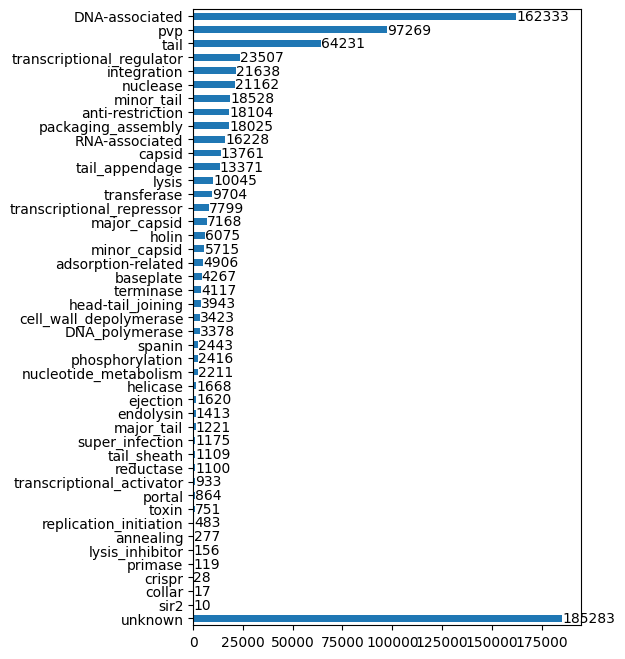

In [28]:
res = (preds.drop(columns=["Annotation", "pc", "host_type"]) > 0.5).sum().sort_values(ascending=True)
to_add = pd.Series([len(preds.loc[preds.Annotation == "unknown"])], index=["unknown"])

bars = pd.concat([to_add, res]).plot.barh(figsize=(5,8))
bars.bar_label(bars.containers[0])
#plt.savefig("pred_unknown_barplot.pdf", bbox_inches="tight")
plt.show()

In [16]:
print(f"Number of proteins that were unknown after HMM with PHROGs: {preds.shape[0]}")
print(f"corresponding to {len(preds.pc.unique())} clusters.\n")

unknown_in_known_pcs = unknown.loc[~unknown.index.isin(phrogs_2nd)].loc[unknown.loc[~unknown.index.isin(phrogs_2nd)].pc.isin(known_pcs)]
print(len(unknown_in_known_pcs), "proteins in clusters containing known annotations")
print("corresponding to", unknown_in_known_pcs.pc.nunique(), "clusters.")

tmp = preds.loc[(preds.Annotation == "unknown") & (~preds.index.isin(unknown_in_known_pcs.index))]
num = tmp.shape[0]
print(f"\nNumber of proteins with still unknown function: {num}")

print(f"Ratio of proteins recuperated from the unknown portion of dataset: {1 - num / preds.shape[0]}")

print("Number of proteins with predicted function", preds.shape[0] - num)

tmp2 = pd.concat([known, unknown])
nclu = tmp2.loc[~tmp2.index.isin(tmp.index)].pc.nunique()
print(f"\nNumber of annotated clusters: {nclu} ({nclu / 197739}%)")

Number of proteins that were unknown after HMM with PHROGs: 483094
corresponding to 150560 clusters.

13889 proteins in clusters containing known annotations
corresponding to 2410 clusters.

Number of proteins with still unknown function: 182863
Ratio of proteins recuperated from the unknown portion of dataset: 0.6214753236430177
Number of proteins with predicted function 300231

Number of annotated clusters: 144985 (0.733213984090139%)


In [39]:
knownPreds = preds.loc[preds.Annotation != "unknown"].index
numCluPred = len(np.unique(list(unknown.loc[unknown.index.isin(knownPreds)].pc.unique()) + list(known.pc.unique())))
numClu = len(np.unique(list(unknown.pc.unique()) + list(known.pc.unique())))
print(numCluPred / numClu, "clusters with predicted function (Empathi + PHROGs).")

0.7329307824961186 clusters with predicted function (Empathi + PHROGs).


In [40]:
general = ["packaging_assembly", "pvp", "nucleotide_metabolism", "RNA-associated", "DNA-associated", "lysis", 
                  "cell_wall_depolymerase", "super_infection", "toxin", "anti-restriction", "crispr", 
                  "sir2", "transferase", "reductase", "adsorption-related", "phosphorylation", "ejection"]

print(preds.loc[:, general].where(preds.loc[:, general] > 0.5).mean().mean(), "average confidence of predictions for general functions.")

0.8063015514294378 average confidence of predictions for general functions.


### Entropy within cluster: do proteins within a cluster recieve the same prediction?

In [6]:
def count_diff(df):
    if len(df.Annotation.unique()) == 1: 
        if len(df) == 1:
            return 0 #singleton cluster
        else:
            return 1 #all prots un cluster have same anno
    elif (len(df.Annotation.unique()) == 2) & ("unknown" in df.Annotation.unique()): 
        return 2 #all prots have same anno with at least one "unknown"
    else:
        list_unique = pd.Series(df.Annotation.unique()).str.split("|")
        
        all_flags = []
        for i in list_unique:
            if "unknown" in i:
                pass
            else:
                for j in i:
                    flag=True
                    for k in list_unique:
                        if k == ["unknown"]:
                            pass
                        elif j not in k:
                            flag=False
                    all_flags.append(flag)
                    
                if np.array(all_flags).any():
                    return 3 # all clusters recieved at least 1 common anno with differences in secondary predictions
                else:
                    return 4 # at least 2 proteins in cluster recieved completely different annotations
        

In [10]:
known_pcs = known.pc.unique()
unknown_pcs = unknown.pc.unique()

pcs_common = set(known_pcs) & set(unknown_pcs)
pcs_only_in_unknown = set(unknown_pcs) - set(known_pcs)
pcs_only_in_known = set(known_pcs) - set(unknown_pcs)


print("# clusters only containing proteins with previously unknown annotations:", len(pcs_only_in_unknown))
print("# clusters only containing proteins with previously known annotations:", len(pcs_only_in_known))
print("# clusters containing proteins with previously known and unknown annotations:", len(pcs_common))

only_unknown = all_preds.loc[all_preds.pc.isin(pcs_only_in_unknown)]
only_known = all_preds.loc[all_preds.pc.isin(pcs_only_in_known)]
common = all_preds.loc[all_preds.pc.isin(pcs_common)]

# clusters only containing proteins with previously unknown annotations: 148359
# clusters only containing proteins with previously known annotations: 46951
# clusters containing proteins with previously known and unknown annotations: 2429


In [11]:
#0 : singleton clusters
#1 : all prots in cluster recieved same annotation
#2 : all prots in cluster recieved same annotation (with at least 1 that recieved no annotation)
#3 : all recieved at least 1 common annotation with certain differences in secondary predictions
#4 : at least 2 proteins in cluster received completely different annotations

counts = all_preds.groupby("pc").apply(count_diff)
display(counts.value_counts())

counts = only_unknown.groupby("pc").apply(count_diff)
display(counts.value_counts())

counts = only_known.groupby("pc").apply(count_diff)
display(counts.value_counts())

counts = common.groupby("pc").apply(count_diff)
display(counts.value_counts())

/tmp/ipykernel_114743/3057668738.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  counts = all_preds.groupby("pc").apply(count_diff)


0    96184
1    67385
3    16418
2    11361
4     6391
Name: count, dtype: int64

/tmp/ipykernel_114743/3057668738.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  counts = only_unknown.groupby("pc").apply(count_diff)


0    75752
1    42678
3    13235
2    10721
4     5973
Name: count, dtype: int64

/tmp/ipykernel_114743/3057668738.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  counts = only_known.groupby("pc").apply(count_diff)


1    23051
0    20432
3     2679
2      473
4      316
Name: count, dtype: int64

/tmp/ipykernel_114743/3057668738.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  counts = common.groupby("pc").apply(count_diff)


1    1656
3     504
2     167
4     102
Name: count, dtype: int64

# Lysin analysis

In [28]:
unknown = pd.read_csv(os.path.join(wd, "tmp/lysin_pvp/unknown/predictions_unknown.csv"), index_col=0).drop(columns="Annotation")
unknown2 = pd.read_csv(os.path.join(wd, "results/unknown/predictions_unknown.csv"), index_col=0).drop(columns=["pvp", "endolysin", "Annotation"])
unknown = pd.merge(unknown, unknown2, how="left", left_index=True, right_index=True)

info = pd.read_pickle(os.path.join(wd, "data/proteins_wUnknown_functions.pkl"))
info = info.loc[~info.index.duplicated()]

unknown = pd.merge(unknown, info.loc[:, ["pc", "host_type"]], left_index=True, right_index=True, how="left")

In [36]:
known = pd.read_csv(os.path.join(wd, "tmp/lysin_pvp/known/predictions_known.csv"), index_col=0)
known2 = pd.read_csv(os.path.join(wd, "results/known/predictions_known.csv"), index_col=0).drop(columns=["pvp", "endolysin", "Annotation"])
known = pd.merge(known, known2, how="left", left_index=True, right_index=True)

info = pd.read_pickle(os.path.join(wd, "data/proteins_wKnown_functions.pkl"))
info = info.loc[~info.index.duplicated()]

known = pd.merge(known, info.loc[:, ["pc", "host_type"]], left_index=True, right_index=True, how="left")

In [30]:
t1 = unknown.loc[(unknown.lysin > 0.5) & (unknown.pvp > 0.5) & (unknown.host_type == "gram-neg")].loc[:,["pvp", "lysin", "tail", "baseplate", "tail_appendage"]]
t2 = known.loc[(known.lysin > 0.5) & (known.pvp > 0.5) & (known.host_type == "gram-neg")].loc[:,["pvp", "lysin", "tail", "baseplate", "tail_appendage"]]
display((pd.concat([t1, t2]) > 0.5).value_counts())


r1 = unknown.loc[(unknown.lysin > 0.5) & (unknown.pvp > 0.5) & (unknown.host_type == "gram-pos")].loc[:,["pvp", "lysin", "tail", "baseplate", "tail_appendage"]]
r2 = known.loc[(known.lysin > 0.5) & (known.pvp > 0.5) & (known.host_type == "gram-pos")].loc[:,["pvp", "lysin", "tail", "baseplate", "tail_appendage"]]

display((pd.concat([r1, r2]) > 0.5).value_counts())

pvp   lysin  tail   baseplate  tail_appendage
True  True   True   True       False             2011
                    False      False              681
                               True               367
             False  False      False              127
Name: count, dtype: int64

pvp   lysin  tail   baseplate  tail_appendage
True  True   True   False      False             3420
             False  False      False              143
             True   True       False               43
                    False      True                13
                    True       True                 1
Name: count, dtype: int64

/home/albou532/venv/jupyter/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/albou532/venv/jupyter/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alway

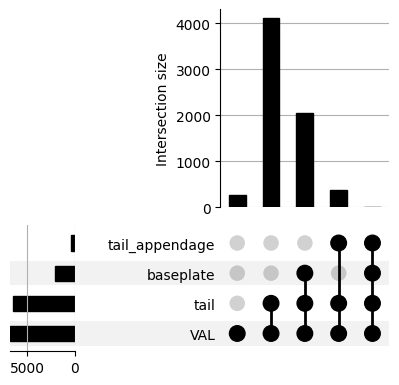

In [31]:
tmp = pd.concat([t1, t2, r1, r2])
tmp["VAL"] = (tmp.pvp > 0.5) & (tmp.lysin > 0.5)
tmp = tmp.drop(columns=["pvp", "lysin"])
plot((tmp > 0.5).value_counts())
#pyplot.savefig("lysin_upsetplot.pdf")
pyplot.show()